# 수집데이터 DB에서 불러오기

In [1]:
import pandas as pd
import numpy as np
import json
from lolchess.model.match import GameType, Match
from lolchess.model.participant import Participant
from lolchess.model.analyze_set5 import AnalyzeSet5

from lolchess.DatabaseManager import DatabaseManager

from sqlalchemy import exists, and_, or_
from Configuration import *

In [2]:
db = DatabaseManager()
df_read = pd.read_sql(db.session.query(Participant) \
              .join(Match) \
              .filter(Participant.is_analyzed == False) \
              .filter(Match.setnumber == 5).statement, db.session.bind)

In [ ]:
df_preprocessing = df_read
df_preprocessing, dropped_idx = preprocessing_trash_rows(df_preprocessing)
for idx in dropped_idx:
    if db.session.query(exists().where(Participant.id == idx)).scalar():
        db.session.query(Participant).filter_by(id=idx).update({"is_analyzed": True})

pre_idx = 0
for idx in myRange(0, len(df_preprocessing), 10000):
    df = df_preprocessing[pre_idx:idx].copy()
    df = preprocessing_split_traits_champions(df)
    for idx_row, row in df.iterrows():
        anaset5 = AnalyzeSet5()
        anaset5.fromDataFrame(row[set5_analyzed_cloumn_names])
        if not db.session.query(exists().where(AnalyzeSet5.participant_id == anaset5.participant_id)).scalar():
            db.session.add(anaset5)
            if db.session.query(exists().where(Participant.id == anaset5.participant_id)).scalar():
                db.session.query(Participant).filter_by(id=anaset5.participant_id).update({"is_analyzed": True})
    pre_idx = idx
    db.session.commit()

In [109]:
df_clustering = df.drop(['id', 
                       'gold_left',
                       'last_round', 
                       'level',
                       'placement',
                       'players_eliminated', 
                       'time_eliminated', 
                       'total_damage_to_players',
                       'match_id',
                       'traits', 
                       'champions'], axis=1)

## sklearn DBSCAN, KMeans

In [110]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

Estimated number of clusters: 14
Estimated number of noise points: 5777
label -1: 5777
label 0: 6967
label 1: 962
label 2: 710
label 3: 252
label 4: 172
label 5: 405
label 6: 229
label 7: 135
label 8: 41
label 9: 62
label 10: 122
label 11: 31
label 12: 57
label 13: 57


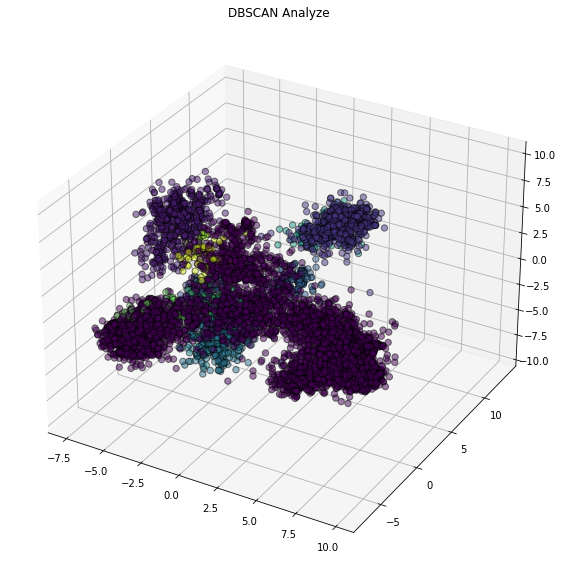

In [141]:
df_db = df_clustering
df_db = StandardScaler().fit_transform(df_db)

# Compute DBSCAN
db = DBSCAN(eps=7.142, min_samples=30).fit(df_db)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
db_labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
db_n_clusters_ = len(set(db_labels)) - (1 if -1 in db_labels else 0)
db_n_noise_ = list(db_labels).count(-1)

print('Estimated number of clusters: %d' % db_n_clusters_)
print('Estimated number of noise points: %d' % db_n_noise_)

unique, counts = np.unique(db_labels, return_counts=True)
for u, c in zip(unique, counts):
    print('label ' + str(u) + ": " + str(c))
count_db_labels = dict(zip(unique, counts))

# 그래프
pca_db = PCA(n_components=3)
X_db_fit_pca = pca_db.fit_transform(df_db)

df_remove_noise = pd.concat([pd.DataFrame(X_db_fit_pca), pd.Series(db_labels, name='label')], axis=1)
df_remove_noise = df_remove_noise.loc[df_remove_noise['label'] > -1]

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_remove_noise[0],df_remove_noise[1],df_remove_noise[2], 
            c=df_remove_noise['label'], cmap='viridis',
            edgecolor='k', s=40, alpha = 0.5)

ax.set_title("DBSCAN Analyze")
ax.dist = 10

plt.autoscale(enable=True, axis='x', tight=True)    

plt.show()

label 0: 1223
label 1: 1624
label 2: 1055
label 3: 938
label 4: 2376
label 5: 1091
label 6: 1118
label 7: 904
label 8: 768
label 9: 1001
label 10: 814
label 11: 778
label 12: 1094
label 13: 1195


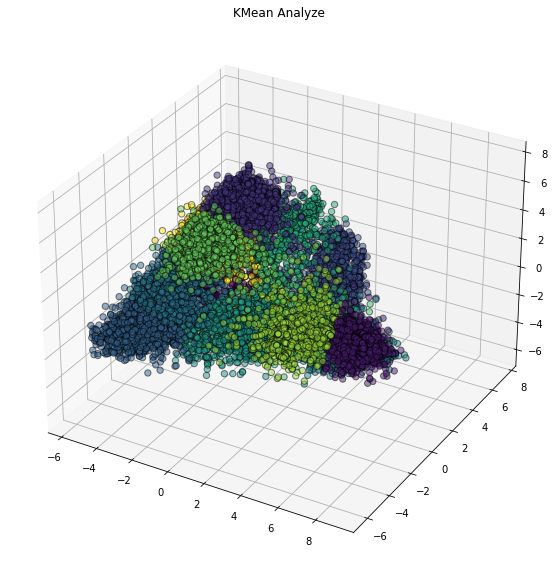

In [142]:
pca_kmean = PCA(n_components=3)
X_kmean_fit_pca = pca_kmean.fit_transform(df_clustering)

kmeans_PCA = KMeans(n_clusters=db_n_clusters_, init='k-means++', max_iter=300, n_init=db_n_clusters_, random_state= 3)

kmeans_labels = kmeans_PCA.fit_predict(X_kmean_fit_pca)
unique, counts = np.unique(kmeans_labels, return_counts=True)
for u, c in zip(unique, counts):
    print('label ' + str(u) + ": " + str(c))
count_kmeans_labels = dict(zip(unique, counts))

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_kmean_fit_pca[:,0],X_kmean_fit_pca[:,1],X_kmean_fit_pca[:,2], 
            c=y_kmeans_PCA, cmap='viridis',
            edgecolor='k', s=40, alpha = 0.5)


ax.set_title("KMean Analyze")
ax.dist = 10

ax.scatter(kmeans_PCA.cluster_centers_[:,0], kmeans_PCA.cluster_centers_[:,1], 
           kmeans_PCA.cluster_centers_[:,2], 
           s = 300, c = 'r', marker='*', label = 'Centroid')

plt.autoscale(enable=True, axis='x', tight=True)    

plt.show()

# 결과 가시화

In [168]:
from lolchess.StaticDataManager import StaticDataManager
sdb = StaticDataManager()

In [160]:
df_result = pd.concat([df, pd.Series(db_labels, name='db_labels')], axis=1)
df_result = pd.concat([df_result, pd.Series(kmeans_labels, name='kmeans_labels')], axis=1)
df_deck_result = df_result.drop(['id',
                           'match_id',
                           'gold_left',
                           'last_round', 
                           'level',
                           'players_eliminated', 
                           'time_eliminated', 
                           'total_damage_to_players', 
                           'traits', 
                           'champions'], axis=1)
#df_deck_result.loc[df_deck_result['db_labels'] == 0].groupby('placement', as_index=False).size().loc[0,'size']

In [166]:
df_deck_result.groupby('db_labels', as_index=False)

In [163]:
df_traits_result = df_deck_result.groupby(['db_labels','placement'],as_index=False).mean()
df_traits_result['placement']

0      1
1      2
2      3
3      4
4      5
      ..
114    4
115    5
116    6
117    7
118    8
Name: placement, Length: 119, dtype: int64

In [165]:
df_traits_result.head(10)

,db_labels,placement,Set5_Assassin_num_units,Set5_Assassin_tier_current,Set5_Brawler_num_units,Set5_Brawler_tier_current,Set5_Caretaker_num_units,Set5_Caretaker_tier_current,Set5_Coven_num_units,Set5_Coven_tier_current,...,TFT5_Syndra_exits,TFT5_Karma_tier,TFT5_Karma_exits,TFT5_Sett_tier,TFT5_Sett_exits,TFT5_Gragas_tier,TFT5_Gragas_exits,TFT5_Riven_tier,TFT5_Riven_exits,kmeans_labels
0,-1,1,0.583199,0.205170,0.668821,0.171244,0.368336,0.368336,0.258481,0.038772,...,0.114701,0.305331,0.159935,0.250404,0.090468,0.126010,0.059774,0.187399,0.088853,6.794830
1,-1,2,0.658284,0.227811,0.642012,0.183432,0.323964,0.323964,0.313609,0.050296,...,0.105030,0.213018,0.115385,0.186391,0.073964,0.124260,0.057692,0.142012,0.073964,7.221893
2,-1,3,0.562678,0.183761,0.745014,0.195157,0.294872,0.294872,0.257835,0.035613,...,0.121083,0.311966,0.170940,0.259259,0.105413,0.143875,0.069801,0.189459,0.103989,7.125356
3,-1,4,0.575209,0.186630,0.660167,0.183844,0.299443,0.299443,0.352368,0.068245,...,0.101671,0.253482,0.143454,0.199164,0.083565,0.165738,0.082173,0.161560,0.083565,7.069638
4,-1,5,0.582633,0.184874,0.665266,0.200280,0.238095,0.238095,0.343137,0.060224,...,0.120448,0.337535,0.193277,0.179272,0.079832,0.184874,0.098039,0.154062,0.082633,7.077031
5,-1,6,0.590226,0.180451,0.685464,0.210526,0.229323,0.229323,0.333333,0.050125,...,0.125313,0.298246,0.177945,0.240602,0.109023,0.216792,0.107769,0.204261,0.114035,7.172932
6,-1,7,0.539340,0.168782,0.692893,0.205584,0.246193,0.246193,0.318528,0.043147,...,0.093909,0.302030,0.184010,0.269036,0.125635,0.243655,0.126904,0.157360,0.096447,7.354061
7,-1,8,0.463255,0.140420,0.624672,0.182415,0.221785,0.221785,0.284777,0.036745,...,0.112861,0.244094,0.154856,0.288714,0.141732,0.171916,0.099738,0.146982,0.089239,7.010499
8,0,1,0.884141,0.330484,0.052232,0.000950,0.024691,0.024691,0.217474,0.000950,...,0.002849,0.004748,0.003799,0.000000,0.000000,0.000950,0.000950,0.042735,0.021842,5.338082
9,0,2,1.142276,0.410569,0.050813,0.000000,0.021341,0.021341,0.218496,0.002033,...,0.003049,0.001016,0.001016,0.000000,0.000000,0.000000,0.000000,0.053862,0.027439,5.273374


In [156]:
print(df_traits_result.loc[2].sort_values(ascending=False).head(30))

match_id                         967.199584
placement                          4.301455
Set5_Spellweaver_num_units         3.880457
Set5_Abomination_num_units         2.913721
Set5_Redeemed_num_units            2.743243
Set5_Mystic_num_units              2.094595
Set5_Spellweaver_tier_current      1.920998
TFT5_Velkoz_tier                   1.847193
TFT5_Brand_tier                    1.822245
Set5_Forgotten_num_units           1.794179
TFT5_Nunu_tier                     1.696466
TFT5_Zyra_tier                     1.651767
TFT5_Ryze_tier                     1.512474
TFT5_Viktor_tier                   1.476091
TFT5_Lux_tier                      1.458420
TFT5_Rell_tier                     1.380457
Set5_Mystic_tier_current           1.103950
db_labels                          1.000000
Set5_Brawler_num_units             0.993763
TFT5_Velkoz_exits                  0.991684
TFT5_Brand_exits                   0.983368
Set5_Abomination_tier_current      0.971933
Set5_Ironclad_num_units         

In [169]:
df_final_result = df_deck_result.groupby('label',as_index=False).size()

KeyError: 'label'

In [283]:
df_final_result.loc[1, 'traits'] = '(빛의 인도자, 군단), (카르마, 가렌, 아이번, 볼리베어)'
df_final_result.loc[2, 'traits'] = '(어둠의 인도자, 군단), (아펠리오스, 다이애나, 다리우스, 모르가나)'
df_final_result.loc[3, 'traits'] = '(구원받은 자, 군단), (렐, 벨코즈, 케일, 레오나)'
df_final_result.loc[4, 'traits'] = '(망각, 군단), (드레이븐, 라이즈, 비에고, 쓰레쉬)'
df_final_result.loc[5, 'traits'] = '(용족, 용 사육사), (하이머딩거, 킨드레드, 볼리베어, 애쉬)'
df_final_result.loc[6, 'traits'] = '(암살자, 어둠의 인도자), (다이애나, 르블랑, 아이번, 비에고)'
df_final_result.loc[7, 'traits'] = '(척후병, 어둠의 인도자 혹은 빛의 인도자), (잭스, 비에고, 판테온, 트런들)'
df_final_result.loc[8, 'traits'] = '(재생술사, 어둠의 인도자 혹은 빛의 인도자), (아이번, 소라카, 리산드라, 블라디미르)'
df_final_result.loc[9, 'traits'] = '(악동, 기병대), (뽀삐, 직스, 클레드, 케넨)'
df_final_result.loc[10, 'traits'] = '(어둠의 인도자, 정찰대), (킨드레드, 다리우스, 타릭, 아펠리오스)'
df_final_result.loc[11, 'traits'] = '(용족, 괴생명체), (하이머딩거, 라이즈, 자이라, 세트)'
#df_final_result.loc[12, 'traits'] = '(Redeemed, Legionnaire), (Rell, Velkoz, Kayle, Leona)'
df_final_result.loc[13, 'traits'] = '(용족, 괴생명체), (라이즈, 누누, 자이라, 세트)'
df_final_result.loc[14, 'traits'] = '(암살자, 어둠의 인도자 혹은 빛의 인도자), (비에고, 다이애나, 아이번, 볼리베어)'
df_final_result.loc[15, 'traits'] = '(어둠의 인도자, 용 사냥꾼), (다이애나, 모데카이저, 르블랑, 리산드라)'
df_final_result.loc[16, 'traits'] = '(악동, 기병대), (티모, 렐, 잭스, 뽀삐)'
df_final_result.loc[17, 'traits'] = '(어둠의 인도자, 정찰대), (다리우스, 킨드레드, 아펠리오스, 타릭)'
df_final_result.loc[18, 'traits'] = '(군단, 빛의 인도자), (모데카이저, 드레이븐, 리븐, 야스오)'
df_final_result.loc[19, 'traits'] = '(어둠의 인도자, 악의 여단), (다이애나, 리산드라, 모르가나, 블라디미르)'
df_final_result.loc[20, 'traits'] = '(군단, 어둠의 인도자), (드레이븐, 라이즈, 다이애나, 렐)'
df_final_result['평균순위'] = round(df_traits_result['placement'], 2)
df_final_result['1등횟수'] = x
df_final_result['승률'] = round((df_final_result['1등횟수'] / df_final_result['size']) * 100, 2)
df_final_result

,label,size,traits,평균순위,1등횟수,승률
0,-1,10666,NaN,4.49,0,0.00
1,0,1045,"(빛의 인도자, 군단), (카르마, 가렌, 아이번, 볼리베어)",4.20,157,15.02
2,1,914,"(어둠의 인도자, 군단), (아펠리오스, 다이애나, 다리우스, 모르가나)",4.30,109,11.93
3,2,601,"(구원받은 자, 군단), (렐, 벨코즈, 케일, 레오나)",4.80,54,8.99
4,3,1477,"(망각, 군단), (드레이븐, 라이즈, 비에고, 쓰레쉬)",4.66,130,8.80
5,4,131,"(용족, 용 사육사), (하이머딩거, 킨드레드, 볼리베어, 애쉬)",4.32,24,18.32
6,5,308,"(암살자, 어둠의 인도자), (다이애나, 르블랑, 아이번, 비에고)",3.82,70,22.73
7,6,414,"(척후병, 어둠의 인도자 혹은 빛의 인도자), (잭스, 비에고, 판테온, 트런들)",4.26,38,9.18
8,7,35,"(재생술사, 어둠의 인도자 혹은 빛의 인도자), (아이번, 소라카, 리산드라, 블라...",5.97,1,2.86
9,8,228,"(악동, 기병대), (뽀삐, 직스, 클레드, 케넨)",5.33,12,5.26


In [286]:
df_final_result.columns = ['라벨', '양', '시너지 및 챔피언', '평균순위', '1등횟수', '승률']
df_final_result = df_final_result.drop([0,12])
df_final_result = df_final_result.drop('라벨', axis=1)

In [294]:
df_final_result.sort_values(by='양', ascending=False).reset_index().drop('index', axis=1)

,양,시너지 및 챔피언,평균순위,1등횟수,승률
0,1477,"(망각, 군단), (드레이븐, 라이즈, 비에고, 쓰레쉬)",4.66,130,8.80
1,1045,"(빛의 인도자, 군단), (카르마, 가렌, 아이번, 볼리베어)",4.20,157,15.02
2,914,"(어둠의 인도자, 군단), (아펠리오스, 다이애나, 다리우스, 모르가나)",4.30,109,11.93
3,601,"(구원받은 자, 군단), (렐, 벨코즈, 케일, 레오나)",4.80,54,8.99
4,414,"(척후병, 어둠의 인도자 혹은 빛의 인도자), (잭스, 비에고, 판테온, 트런들)",4.26,38,9.18
5,308,"(암살자, 어둠의 인도자), (다이애나, 르블랑, 아이번, 비에고)",3.82,70,22.73
6,228,"(악동, 기병대), (뽀삐, 직스, 클레드, 케넨)",5.33,12,5.26
7,194,"(악동, 기병대), (티모, 렐, 잭스, 뽀삐)",3.31,53,27.32
8,187,"(암살자, 어둠의 인도자 혹은 빛의 인도자), (비에고, 다이애나, 아이번, 볼리베어)",4.21,30,16.04
9,178,"(용족, 괴생명체), (하이머딩거, 라이즈, 자이라, 세트)",5.21,8,4.49


## 아이템 분석

In [94]:
from sklearn.preprocessing import MultiLabelBinarizer

In [102]:
def GetItems(match):
    if match['metadata']['data_version'] != '5':
        return pd.DataFrame()
    df_participants = pd.DataFrame(match['info']['participants'])
    df_participants['list_items'] = np.empty((len(df_participants), 0)).tolist()
    for idx_participant, df_participant in df_participants.iterrows():
        for idx, row in pd.DataFrame(df_participant['traits']).iterrows():
            if not 'Set5' in row['name']:
                return pd.DataFrame()
    
        df_participant_units = pd.DataFrame(df_participant['units'])
        for idx, row in df_participant_units.iterrows():
            df_participants.iloc[idx_participant]['list_items'].extend(row['items'])
            
    return df_participants

def GetItemOntHot(matches):
    if matches == None:
        return None
    df_items = GetItems(matches[0])
    for match in matches[1:]:
        df_temp_items = GetItems(match)
        if df_temp_items.empty:
            continue
        df_items = pd.concat([df_items, df_temp_items], ignore_index=True, sort=False).fillna(0)
    
    mlb = MultiLabelBinarizer(sparse_output=True)
    df_items = df_items.join(
                    pd.DataFrame.sparse.from_spmatrix(
                    mlb.fit_transform(df_items.pop('list_items')),
                    index=df_items.index,
                    columns=mlb.classes_))
    return df_items

In [122]:
df_items = GetItemOntHot(matches).drop(['companion', 
                                       'gold_left',
                                       'last_round', 
                                       'level',
                                       'players_eliminated', 
                                       'puuid', 
                                       'time_eliminated', 
                                       'total_damage_to_players', 
                                       'traits', 
                                       'units'], axis=1)

In [147]:
df_items.groupby(['placement'],as_index=False).sum()

,placement,1,2,3,4,5,6,7,9,11,...,1059,1066,1067,1069,1077,1099,1148,1168,1178,1189
0,1,0,0,0,0,1,0,1,1,1,...,1,0,1,1,0,0,0,1,0,1
1,2,1,0,1,1,1,0,0,0,1,...,0,1,0,1,0,0,0,0,0,0
2,3,1,1,0,1,0,0,2,0,1,...,0,1,0,1,1,0,0,0,0,0
3,4,0,1,0,2,0,2,2,0,0,...,1,1,0,0,0,0,1,0,1,0
4,5,0,0,1,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
5,6,1,0,0,0,0,0,2,0,1,...,0,0,1,0,0,1,0,0,0,0
6,7,0,0,0,1,0,1,0,0,0,...,0,0,0,1,0,1,0,0,0,0
7,8,0,0,1,0,0,0,1,1,0,...,0,0,0,1,1,0,0,1,0,0


# 버려진 코드

In [ ]:
def GetPostParticipant(match):
    if match['metadata']['data_version'] != '5':
        return pd.DataFrame()
    df_participants = pd.DataFrame(match['info']['participants'])
    for idx_participant, df_participant in df_participants.iterrows():
        # 시너지(traits)
        df_participant_traits = pd.DataFrame(df_participant['traits'])
        df_participant_traits_splited = pd.DataFrame([0])
        for idx, row in df_participant_traits.iterrows():
            df_participant_traits_trait = df_participant_traits.loc[idx:idx].drop(['name', 'tier_total'], axis=1).add_prefix(row['name'] + '_')
            df_participant_traits_trait.index = [0]
            df_participant_traits_splited = df_participant_traits_splited.join(df_participant_traits_trait)
        df_participant_traits_splited.index = [idx_participant]
        df_participant_traits_splited = df_participant_traits_splited.drop(0, axis=1)
        df_participants = pd.concat([df_participants, df_participant_traits_splited], axis=1).fillna(0)
        
        # 유닛들(units)
        df_participant_units = pd.DataFrame(df_participant['units'])
        df_participant_units_splited = pd.DataFrame([0])
        for idx, row in df_participant_units.iterrows():
            df_participant_units_unit = df_participant_units.loc[idx:idx].drop(['character_id', 'items', 'name', 'rarity'], axis=1)
            if 'chosen' in df_participant_units.loc[idx:idx].columns.tolist():
                df_participant_units_unit = df_participant_units_unit.drop(['chosen'], axis=1)
            df_participant_units_unit = df_participant_units_unit.add_prefix(row['character_id'] + '_')
            df_participant_units_unit.index = [0]
            df_participant_units_splited = pd.concat([df_participant_units_splited, df_participant_units_unit], axis=1).fillna(0)
        df_participant_units_splited = df_participant_units_splited.T.groupby(level=0).agg(max).T
        df_participant_units_splited.index = [idx_participant]
        df_participant_units_splited = df_participant_units_splited.drop(0, axis=1)
        df_participants = pd.concat([df_participants, df_participant_units_splited], axis=1).fillna(0)
        
    df_participants = df_participants.T.groupby(level=0).agg(max).T
    return df_participants

In [ ]:
df_match = GetPostParticipant(matches[0])
for match in matches[1:]:
    df_temp_match = GetPostParticipant(match)
    if df_temp_match.empty:
        continue
    df_match = pd.concat([df_match, df_temp_match], ignore_index=True, sort=False)
    df_match = df_match.fillna(0)